# Reaction-diffusion, metamodeling with 2 homogenous parameters

$$
\begin{cases}
\frac{\partial}{\partial t} u(t,x)=D\Delta u(t,x) + u(t,x)(r - \gamma u(t,x)), t\geq 0, x\in \Omega, \Omega=[0, 50]^2\\
\frac{\partial u(t,x)}{\partial n}\Big|_{x\in\partial\Omega}=\nabla u(t,x)\cdot n=0, t\geq0,\text{Neumann condition},\\
u(0,x)=u_0(x),x\in \Omega
\end{cases}
$$

In all that follows,

- $\gamma=1$
- $D$ is a scalar in $[0.05, 1.]$ homogeneous in space and time
- $r$ is a scalar in $[0.05, 0.15]$ homogenous in space and time

**We want to build a metamodel and thus, learn the solution $u(t, x)$ of the above problem for all $D$ and for all $r$**

**Note that for a more peaked initial condition one would require hard constraint on the PINN or RAR sampling on the initial condition**



In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Float64 and GPU settings

In [2]:
#import os; os.environ["JAX_ENABLE_X64"] = "TRUE" # comment/uncomment to  disable/enable float64 for JAX
#import os; os.environ["CUDA_VISIBLE_DEVICES"]="" # If uncommented then GPU is disable


Import our package

In [3]:
import jinns


Import other dependencies

In [4]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
from functools import partial

import matplotlib.pyplot as plt

key = random.PRNGKey(2)


Data Generator

In [5]:
n = 1000
nb = 500
nt = 1000
omega_batch_size = 32
temporal_batch_size = 32
omega_border_batch_size = 32
dim = 2
xmin = 0
xmax = 50
ymin = 0
ymax = 50
tmin = 0
tmax = 1
method = "uniform"

# rar_parameters = {
#     'start_iter':1000, # the gradient step at which RAR algo starts (enables a burn in period)
#     'update_rate':500, # nb of gradient steps between two RAR procedures
#     'sample_size':100, # the size of the sample of collocation points from which the new collocation points will be taken
#     'selected_sample_size':5, # the number of selected collocation points from the sample, to join the dataset.
# }
# n_start = 500 # the initial number of collocation points at beginning


Tmax = 50
key, subkey = random.split(key)
train_data = jinns.data.CubicMeshPDENonStatio(
    subkey,
    n,
    nb,
    nt,
    omega_batch_size,
    omega_border_batch_size,
    temporal_batch_size,
    dim,
    (xmin, ymin),
    (xmax, ymax),
    tmin,
    tmax,
    method,
)

Initial condition

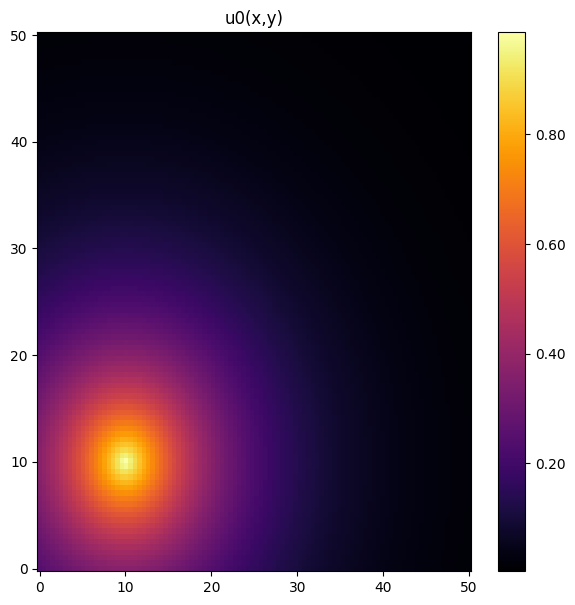

In [6]:
from jax.scipy.stats import norm
sigma_init = 1 * jnp.ones((2))
mu_init = jnp.array([10., 10.]) #jnp.array([25 / xmax, 25 / ymax])

def u0(x):
    return jnp.exp(-jnp.linalg.norm(x - mu_init) / 10.)

v_u0 = jax.vmap(u0)

nx, ny = 100, 100
val_xy_data = [
    jnp.linspace(xmin, xmax, nx),
    jnp.linspace(ymin, ymax, ny)
              ]

jinns.data.plot2d(
    fun=u0,
    xy_data=val_xy_data,
    title="u0(x,y)"
)

PINN creation

In [7]:
eqx_list = [
    [eqx.nn.Linear, 5, 60],
    [jax.nn.swish],
    [eqx.nn.Linear, 60, 60],
    [jax.nn.swish],
    [eqx.nn.Linear, 60, 60],
    [jax.nn.swish],
    [eqx.nn.Linear, 60, 60],
    [jax.nn.swish],
    [eqx.nn.Linear, 60, 1],
    [jax.nn.softplus]
]
key, subkey = random.split(key)

def input_transform(t_x, params):
    # t_x = t_x.at[..., 1].set(t_x[...,1] / xmax)
    # t_x = t_x.at[...,2].set(t_x[...,2] / ymax)
    # t_x = t_x.at[...,0].set(t_x[...,0] / tmax)
    return jnp.concatenate([t_x, params["eq_params"]["D"], params["eq_params"]["r"]], axis=-1)

# def output_transform(pinn_in, pinn_out):
#     """
#     Hard constraint for the initial condition (see eg https://arxiv.org/abs/2102.04626)
#     Physics-informed neural networks with hard constraints for inverse design, Lu Lu et al., 2021
#     """
#     t = pinn_in[0]
#     return (1-t)*u0(pinn_in[1:]) + t * pinn_out

u = jinns.utils.create_PINN(subkey, eqx_list, "nonstatio_PDE", 2, input_transform=input_transform)#, output_transform=output_transform)

In [8]:
init_nn_params = u.init_params()

Additional batch for the parameters

In [9]:
method = "grid"
key, subkey = random.split(key)
np = 1024
param_batch_size = 32*32 # must be equal to omega_batch_size * time_batch_size !
param_train_data = jinns.data.DataGeneratorParameter(
    subkey,
    np,
    param_batch_size,
    {"D":(0.05, 1.)},# "r":(0.05, 0.15)},
    method,
)

### True model parameters and parameter initialization

In [10]:
D = 0.5
g = 1.
r = 0.1


Note that we feed the parameters obtained from the additional batch into the classical dictionary of parameters

In [11]:
init_params = {
    "nn_params":init_nn_params,
    "eq_params":{
        **param_train_data.get_batch(), # The additional batch is a dict
        "g":jnp.array([g]),
         #"D":jnp.array([D]),
         "r":jnp.array([r])
    }
}

The spatial heterogeneity of $r$ is introduced through a user defined function which recreates the spatial map

### Loss construction

In [12]:
from jinns.loss._DynamicLossAbstract import PDENonStatio
from jinns.loss._operators import _laplacian_rev

class FisherKPP_reparametrized(PDENonStatio):
    r"""
    Return the Fisher KPP dynamic loss term. Dimension of :math:`x` can be
    arbitrary

    .. math::
        \frac{\partial}{\partial t} u(t,x)=D\Delta u(t,x) + u(t,x)(r(x) - \gamma(x)u(t,x))

    """

    def __init__(self, Tmax=1, eq_params_heterogeneity=None):
        super().__init__(Tmax, eq_params_heterogeneity)

    @PDENonStatio.evaluate_heterogeneous_parameters
    def evaluate(self, t, x, u, params):
        # Note that the last dim of u is nec. 1
        u_ = lambda t, x: u(t, x, params)[0]

        du_dt = jax.grad(u_, 0)(t, x)

        lap = _laplacian_rev(t, x, u, params)[..., None]

        return du_dt + self.Tmax * (
            - params["eq_params"]["D"] * lap
            - params["eq_params"]["r"] * u(t, x, params)
            * (
                1 - params["eq_params"]["g"] * u(t, x, params)
            )
        )

fisher_dynamic_loss = FisherKPP_reparametrized(Tmax=Tmax)

In [13]:
loss_weights = {"dyn_loss":1., "initial_condition": 1. * Tmax, "boundary_loss":1. * Tmax}

loss = jinns.loss.LossPDENonStatio(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=fisher_dynamic_loss,
    omega_boundary_fun=lambda t, dx: 0,
    omega_boundary_condition="neumann",
    initial_condition_fun=u0,
    norm_key=None,
    norm_borders=None,
    norm_samples=None
)


In [14]:
from jinns.data import append_param_batch

losses_and_grad = jax.value_and_grad(loss, 0, has_aux=True)
losses, grads = losses_and_grad(
    init_params,
    #train_data.get_batch(),#
    append_param_batch(train_data.get_batch(), param_train_data.get_batch())
)


l_tot, d = losses
print(f"total loss: {l_tot}")
print(f"Individual losses: { {key: f'{val:.2f}' for key, val in d.items()} }")


total loss: 16.958274841308594
Individual losses: {'boundary_loss': '0.32', 'dyn_loss': '1.12', 'initial_condition': '15.52', 'norm_loss': '0.00', 'observations': '0.00', 'sobolev': '0.00'}


### Learning the neural network parameters
The learning process here consider known equation parameters `eq_params`. We thus only update `nn_params`

In [15]:
params = init_params


In [16]:
# Optimizer
import optax
tx = optax.adam(learning_rate=1e-3)


In [17]:
n_iter = 50000


In [18]:
params, total_loss_list, loss_by_term_dict, train_data, loss, _, _ = jinns.solve(
    init_params=params,
    data=train_data,
    param_data=param_train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter,
)

  0%|          | 0/50000 [00:00<?, ?it/s]

Iteration 0: loss value = 13.173978805541992
Iteration 1000: loss value = 0.2569841146469116
Iteration 2000: loss value = 0.12419749796390533
Iteration 3000: loss value = 0.050809506326913834
Iteration 4000: loss value = 0.05128195881843567
Iteration 5000: loss value = 0.019823726266622543
Iteration 6000: loss value = 0.03077702783048153
Iteration 7000: loss value = 0.013941100798547268
Iteration 8000: loss value = 0.025198377668857574
Iteration 9000: loss value = 0.03430900350213051
Iteration 10000: loss value = 0.01636020839214325
Iteration 11000: loss value = 0.016424043104052544
Iteration 12000: loss value = 0.014416047371923923
Iteration 13000: loss value = 0.014668071642518044
Iteration 14000: loss value = 0.01838579960167408
Iteration 15000: loss value = 0.01018137764185667
Iteration 16000: loss value = 0.014124692417681217
Iteration 17000: loss value = 0.012219742871820927
Iteration 18000: loss value = 0.013040273450314999
Iteration 19000: loss value = 0.013423156924545765
Iter

### Results

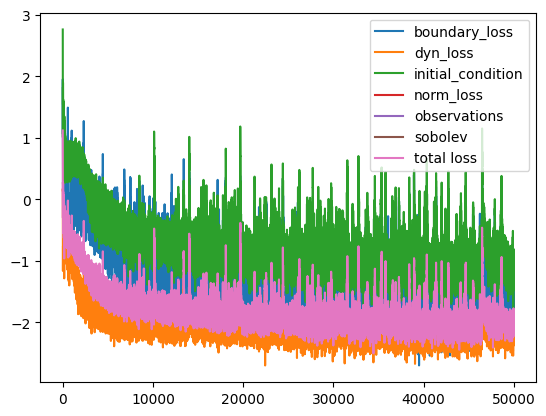

In [19]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_weights[loss_name] * loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();


Plot the PDE solution learned by the PINN

In [20]:
times = jnp.round(jnp.array([0, 1., 10., 25, 48, 50]) / Tmax, decimals=2) #2/tmax,5.56/tmax, 0.25, 0.5, 0.75, 1] # times in the rescaled time scale
nx, ny = 50, 50
val_xy_data = [
    jnp.linspace(xmin, xmax, nx),
    jnp.linspace(ymin, ymax, ny)
]

50 50
[0.11596554]


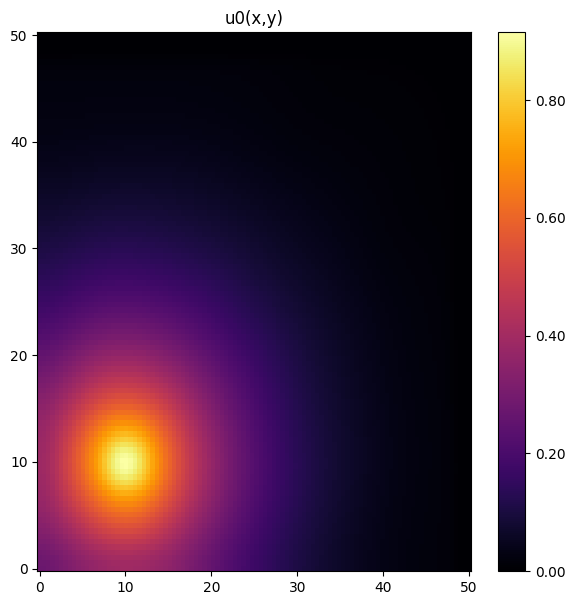

In [21]:
u_est = lambda x: u(jnp.array([0.]), x, {"nn_params":params["nn_params"], "eq_params":{"g":g, "D":jnp.array([0.5]), "r":jnp.array([0.1])}})
nx, ny = 100, 100
print(xmax, ymax)
val_xy_data = [jnp.linspace(xmin, xmax, nx),
               jnp.linspace(ymin, ymax, ny)
              ]
print(u_est(jnp.array([25, 25])))
jinns.data.plot2d(
    fun=u_est,
    xy_data=val_xy_data,
    title="u0(x,y)"
)

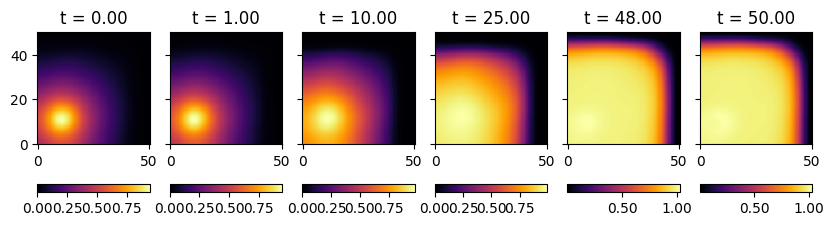

In [22]:
u_est = lambda t, x: u(t, x, {"nn_params":params["nn_params"], "eq_params":{"g":g, "D":jnp.array([0.1]), "r":jnp.array([1.])}})
jinns.data.plot2d(
    fun=u_est,
    xy_data=val_xy_data,
    times = times,
    Tmax=Tmax,
    title="u0(x,y)",
    figsize=(10, 10*len(times))
)

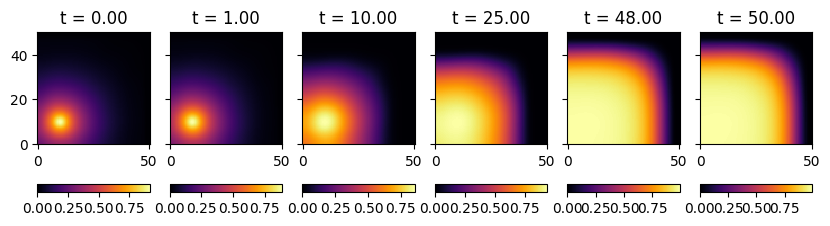

In [23]:
u_est = lambda t, x: u(t, x, {"nn_params":params["nn_params"], "eq_params":{"g":g, "D":jnp.array([0.5]), "r":jnp.array([0.1])}})
jinns.data.plot2d(
    fun=u_est,
    xy_data=val_xy_data,
    times = times,
    Tmax=Tmax,
    title="u0(x,y)",
    figsize=(10, 10*len(times))
)

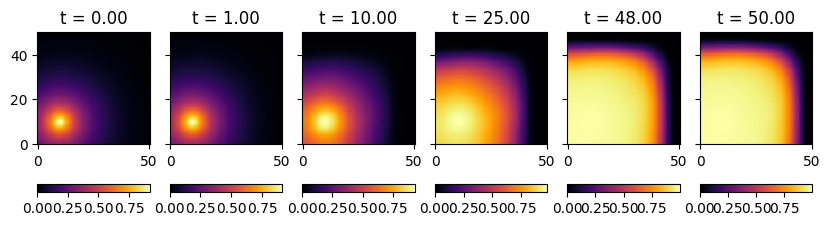

In [24]:
u_est = lambda t, x: u(t, x, {"nn_params":params["nn_params"], "eq_params":{"g":g, "D":jnp.array([0.05]), "r":jnp.array([0.05])}})
jinns.data.plot2d(
    fun=u_est,
    xy_data=val_xy_data,
    times = times,
    Tmax=Tmax,
    title="u0(x,y)",
    figsize=(10, 10*len(times))
)

## Compare the results with diffrax solver

In [25]:
from jinns.experimental import diffrax_solver, SpatialDiscretisation, laplacian, plot_diffrax_solution, neumann_boundary_condition
import diffrax

In [26]:
# from jax.scipy.stats import norm
# sigma_init = 1 * jnp.ones((2))
# mu_init = jnp.array([10., 10.])

# def u0(x):
#     return jnp.exp(-jnp.linalg.norm(x - mu_init) * 1)

# nx, ny = 50, 50
# val_xy_data = [jnp.linspace(xmin, 50, nx),
#                jnp.linspace(ymin, 50, ny)
#               ]

# jinns.data.plot2d(
#     fun=u0,
#     xy_data=val_xy_data,
#     title="u0(x,y)"
# )

In [27]:
# --- PDE solution for true parameters
true_params = {
    "D": jnp.array(0.5),
    "r": jnp.array(0.1),
}

# Spatial discretisation
xmin, xmax = 0, 50
ymin, ymax = 0, 50
nx, ny = 50, 50

y0 = SpatialDiscretisation.discretise_fn(xmin, xmax, ymin, ymax, nx, ny, u0)

# Temporal discretisation
times = jnp.linspace(tmin, Tmax, 10)

# Tolerances for non-stiff problems
rtol = 1e-3
atol = 1e-6
# Tolerances for stiff problems (along with using float64)
# rtol = 1e-7
# atol = 1e-9
stepsize_controller = diffrax.PIDController(
    pcoeff=0.3, icoeff=0.4, rtol=rtol, atol=atol, dtmax=0.001
)

solver = diffrax.Tsit5()
max_steps = int(1e6)
saveat = (times,)

pde_control = {
    "xboundary": (xmin, xmax),
    "yboundary": (ymin, ymax),
    "nx": nx,
    "ny": ny,
    "ode_hyperparams": {
        "t0": tmin,
        "t1": Tmax,
        "dt0": None,
        "y0": y0,
        "saveat": diffrax.SaveAt(ts=times),
        "stepsize_controller": stepsize_controller,
        "max_steps": max_steps,
        "solver": diffrax.Tsit5(),
    },
}


D = true_params["D"]
r = true_params["r"]

def vector_field(t, y, args):
    #y = neumann_boundary_condition(y)
    vf = D * laplacian(y) + r * y * (1 - y)
    vf = neumann_boundary_condition(vf)
    return vf

# Prepare ODE object on discretized problem
term = diffrax.ODETerm(vector_field)


In [28]:
%%time
diffrax_solution = diffrax_solver(pde_control, term)

CPU times: user 14.7 s, sys: 42.2 ms, total: 14.8 s
Wall time: 14.7 s


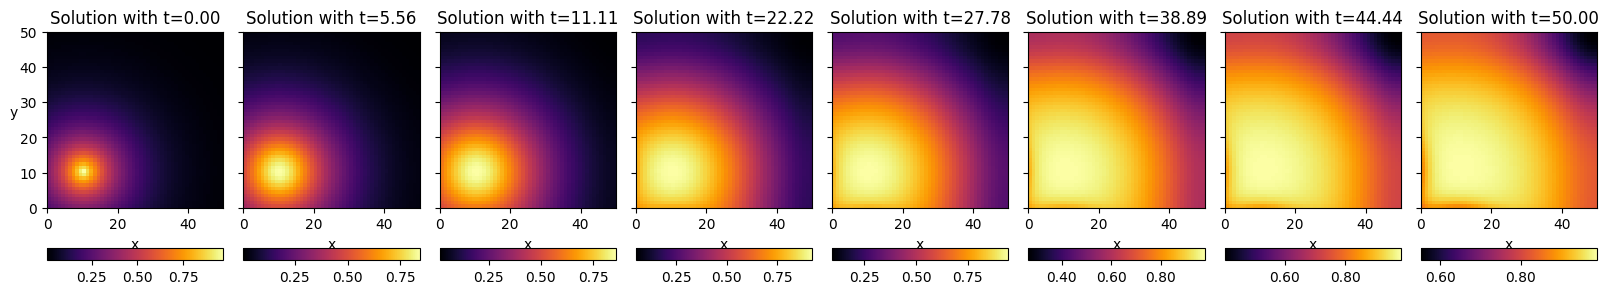

In [29]:
plot_diffrax_solution(diffrax_solution, nplot=8, pde_control=pde_control)

In [30]:
%%time
diffrax_solution = diffrax_solver(pde_control, term)

CPU times: user 13.1 s, sys: 2.58 ms, total: 13.1 s
Wall time: 13.1 s
